In [1]:
# import statements and module configuration

__author__ = 'davidmurphy'


import os
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from skmisc import loess
#sns.set(style="darkgrid")

# set high DPI on figures globally
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12


/home/amster_guy/anaconda2/lib/python2.7/site-packages/skmisc/loess/__init__.py:51: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._loess import (loess, loess_model, loess_inputs, loess_control,
/home/amster_guy/anaconda2/lib/python2.7/site-packages/skmisc/loess/__init__.py:51: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  from ._loess import (loess, loess_model, loess_inputs, loess_control,


In [2]:
"""
BINNED DATA ANALYSIS TOOLS
"""


class FilePaths:
    """structure organizing file paths and directories used for X/A analyses"""
    def __init__(self):
        # XA analysis path
        self.root = os.getcwd()

        # aut bval file path, X & A b-index file paths
        self.abval_file = '{}/aut.bval.x_aut_ratios.npz'.format(self.root)
        self.xbidx_file = '{}/x.bidx.x_aut_ratios.npz'.format(self.root)
        self.bidx_file = '{}/aut.bidx.x_aut_ratios.npz'.format(self.root)

        # aut dist file path, X & A dist index file paths
        self.adist_file = '{}/aut.dist.npz'.format(self.root)
        self.xdidx_file = '{}/x.didx.npz'.format(self.root)
        self.didx_file = '{}/aut.didx.x_aut_ratios.npz'.format(self.root)

    def fbval(self, chrom):
        """bval file paths for individual chrom"""
        return '{}/bvals/{}.bvals.x_aut_ratios.npz'.format(self.root, chrom)

    def fdist(self, chrom):
        """dist file paths for individual chrom"""
        return '{}/dists/{}.mindists.x_aut_ratios.npz'.format(self.root, chrom)

    def fpi(self, chrom, neut):
        """pi file paths for individual chrom and population"""
        return '{}/pivals/{}.{}.pi.x_aut_ratios.npz'.format(self.root, chrom, neut)

    def fapi(self, neut):
        """joined aut pi values for specific population (=neut)"""
        return '{}/aut.{}.pi.x_aut_ratios.npz'.format(self.root, neut)

    def fdiv(self, chrom, outg):
        """ div file paths for individual chrom and outgroup"""
        return '{}/dvals/{}.{}.d.x_aut_ratios.npz'.format(self.root, chrom, outg)

    def fadiv(self, outg):
        """joined aut div values for specific population (=neut)"""
        return '{}/aut.{}.div.x_aut_ratios.npz'.format(self.root, outg)

    def fbinpi(self, neut, sortby):
        """binned X & A pi values"""
        return '{}/saves/{}.pi.s{}.x_aut_ratios.npz'.format(self.root, neut, sortby)

    def fbindiv(self, outg, sortby):
        """binned X & A div values"""
        return '{}/saves/{}.div.s{}.x_aut_ratios.npz'.format(self.root, outg, sortby)

    def fbincnt(self, sortby):
        """bins of sort values, X & A neutral site counts per bin"""
        return '{}/saves/cnts.s{}.x_aut_ratios.npz'.format(self.root, sortby)
    

class BinnedData:
    """a structure that holds binned data and its properties"""
    def __init__(self, ch, neut, outg, sortby, minCnt=1):
        # initialize FilePaths object to retrieve saved files
        fpth = FilePaths()

        # load bins edges and bin counts
        za = np.load(fpth.fbincnt(sortby))
        bins = za['bins']
        cnt = za[ch+'cnt']  # NOTE: ch is either x or a for X/Aut
        
        # correct .bins to show average bin value
        if sortby == 'bval':
            bins = 0.001*np.asarray([0.25]+range(1,1000)+[999.75])
        else:
            pass
        
        # load pi & div
        pi = np.load(fpth.fbinpi(neut, sortby))[ch+'pi']
        div = np.load(fpth.fbindiv(outg, sortby))[ch+'div']
        
        assert len(pi) == len(bins)
        
        # merge bins with less than minCnt together:
        merged, currCnt = [[]], 0
        for i in xrange(len(bins)):
            if currCnt >= minCnt:
                merged.append([])
                currCnt = 0
            if cnt[i] > 0:
                merged[-1].append(i)
                currCnt += cnt[i]
        if len(merged[-1]) == 0:
            merged = merged[:-1]
        nBins, nCnt, nPi, nDiv = [], [], [], []
        for m in merged:
            nCnt.append(float(np.sum([cnt[i] for i in m])))
            assert nCnt[-1] > 0.0
            nBins.append(np.sum([float(bins[i])*cnt[i]/nCnt[-1] for i in m]))
            nPi.append(np.sum([pi[i]*cnt[i]/nCnt[-1] for i in m]))
            nDiv.append(np.sum([div[i]*cnt[i]/nCnt[-1] for i in m]))
        
        self.bins = np.asarray(nBins)
        self.cnt = np.asarray(nCnt)
        self.pi = np.asarray(nPi)
        self.div = np.asarray(nDiv)
        for a in [self.bins, self.cnt, self.pi, self.div]:
            assert not np.isnan(a).any()

        # create an x-axis label for plots baesd on the sorting type
        if sortby == 'dist':
            self.xlab = 'cM to nearest exon'
        else:
            self.xlab = 'B values'

    @property
    def pi_div(self):
        """pi/D (use masked pi & div by default to avoid division by 0)"""
        return self.pi / self.div

    @property
    def tot_cnt(self):
        """get the total number of neutral sites summed across bins"""
        return np.sum(self.cnt, dtype='f8')

In [3]:
def fit_loess(xi, yi, wts, span):
    """get loess fitted values for each xi input"""
    lo = loess.loess(xi, yi, weights=wts, span=span)
    lo.fit()

    return lo.outputs.fitted_values


def predict_loess(xi, yi, wts, span,xtest):
    """get loess predicted values at new points from xtest"""
    lo = loess.loess(xi, yi, weights=wts, span=span)
    lo.fit()
    predict = lo.predict(xtest)

    # NOTE: copy prevents a bug where repeated calls affected previous results
    return np.copy(predict.values)

In [22]:
"""
BINNED DATA BASIC PLOTS
"""


def plot_1(a, x, span):
    """plot pi vs cM to exon or B value"""
    mpl.rcParams['figure.dpi'] = 500
    mpl.rcParams['axes.titlesize'] = 16
    mpl.rcParams['axes.labelsize'] = 14
    mpl.rcParams['xtick.labelsize'] = 14
    mpl.rcParams['ytick.labelsize'] = 14
    mpl.rcParams['legend.fontsize'] = 12

    # plot log10 neutral site counts per bin
    plt.figure(figsize=(10, 12))
    ax = plt.subplot(411)
    ax.spines["top"].set_visible(True)
    plt.scatter(a.bins, np.log10(a.cnt), color='mediumorchid', s=0.4)
    plt.scatter(x.bins, np.log10(x.cnt), color='darkturquoise', s=0.4)
    plt.ylabel('Number of sites\n(log-10)')
    plt.xlim(0, 1)
    plt.text(0.025, 7.0, 'A', va='center', ha='center',fontsize=14)
    plt.xticks(color='white')
    divByB, iMin = False, 0
    for i in xrange(2,5):
        ax = plt.subplot(4,1,i)    
        
        if divByB:
            dena, denx = a.bins, x.bins
        else:
            dena, denx = 1.0, 1.0

        # plot LOESS smoothed div for X
        xtest = min(x.bins) + (max(x.bins)-min(x.bins))*np.arange(0.0,1.0001,0.0001)
        xpd = predict_loess(x.bins, x.pi_div/denx, x.cnt, span, xtest)
        lbl = r'X'
        clr = 'darkturquoise'
        if i == 4:
            iMin = min([j for j in xrange(len(xpd)) if max(np.abs(xpd)[j:]) <= 0.1 ])
            plt.ylim(0, .1)
        else:
            plt.xticks(color='white')
        xtest, xpd = xtest[iMin:], xpd[iMin:]
        
        if i==2:
            plt.text(0.025, .016, 'B', va='center', ha='center',fontsize=14)
        elif i==3:
            plt.text(0.025, 25, 'C', va='center', ha='center',fontsize=14)
        elif i==4:
            plt.text(0.025, .08, 'D', va='center', ha='center',fontsize=14)
            plt.xlabel(a.xlab)

        plt.plot(xtest, xpd, color=clr, label=lbl)
        
        
        xtest = min(a.bins) + (max(a.bins)-min(a.bins))*np.arange(0.0,1.0001,0.0001)
        apd = predict_loess(a.bins, a.pi_div/dena, a.cnt, span, xtest)
        lbl = r'Autosomes'
        clr = 'mediumorchid'
        xtest, apd = xtest[iMin:], apd[iMin:]
        plt.plot(xtest, apd, color=clr, label=lbl)
        plt.ylabel(r'$\pi/D$')
        if divByB:
            plt.ylabel(r'$\pi/DB$')
        if not divByB:
            plt.legend(loc=9)
        divByB = True
        
        
    plt.show()



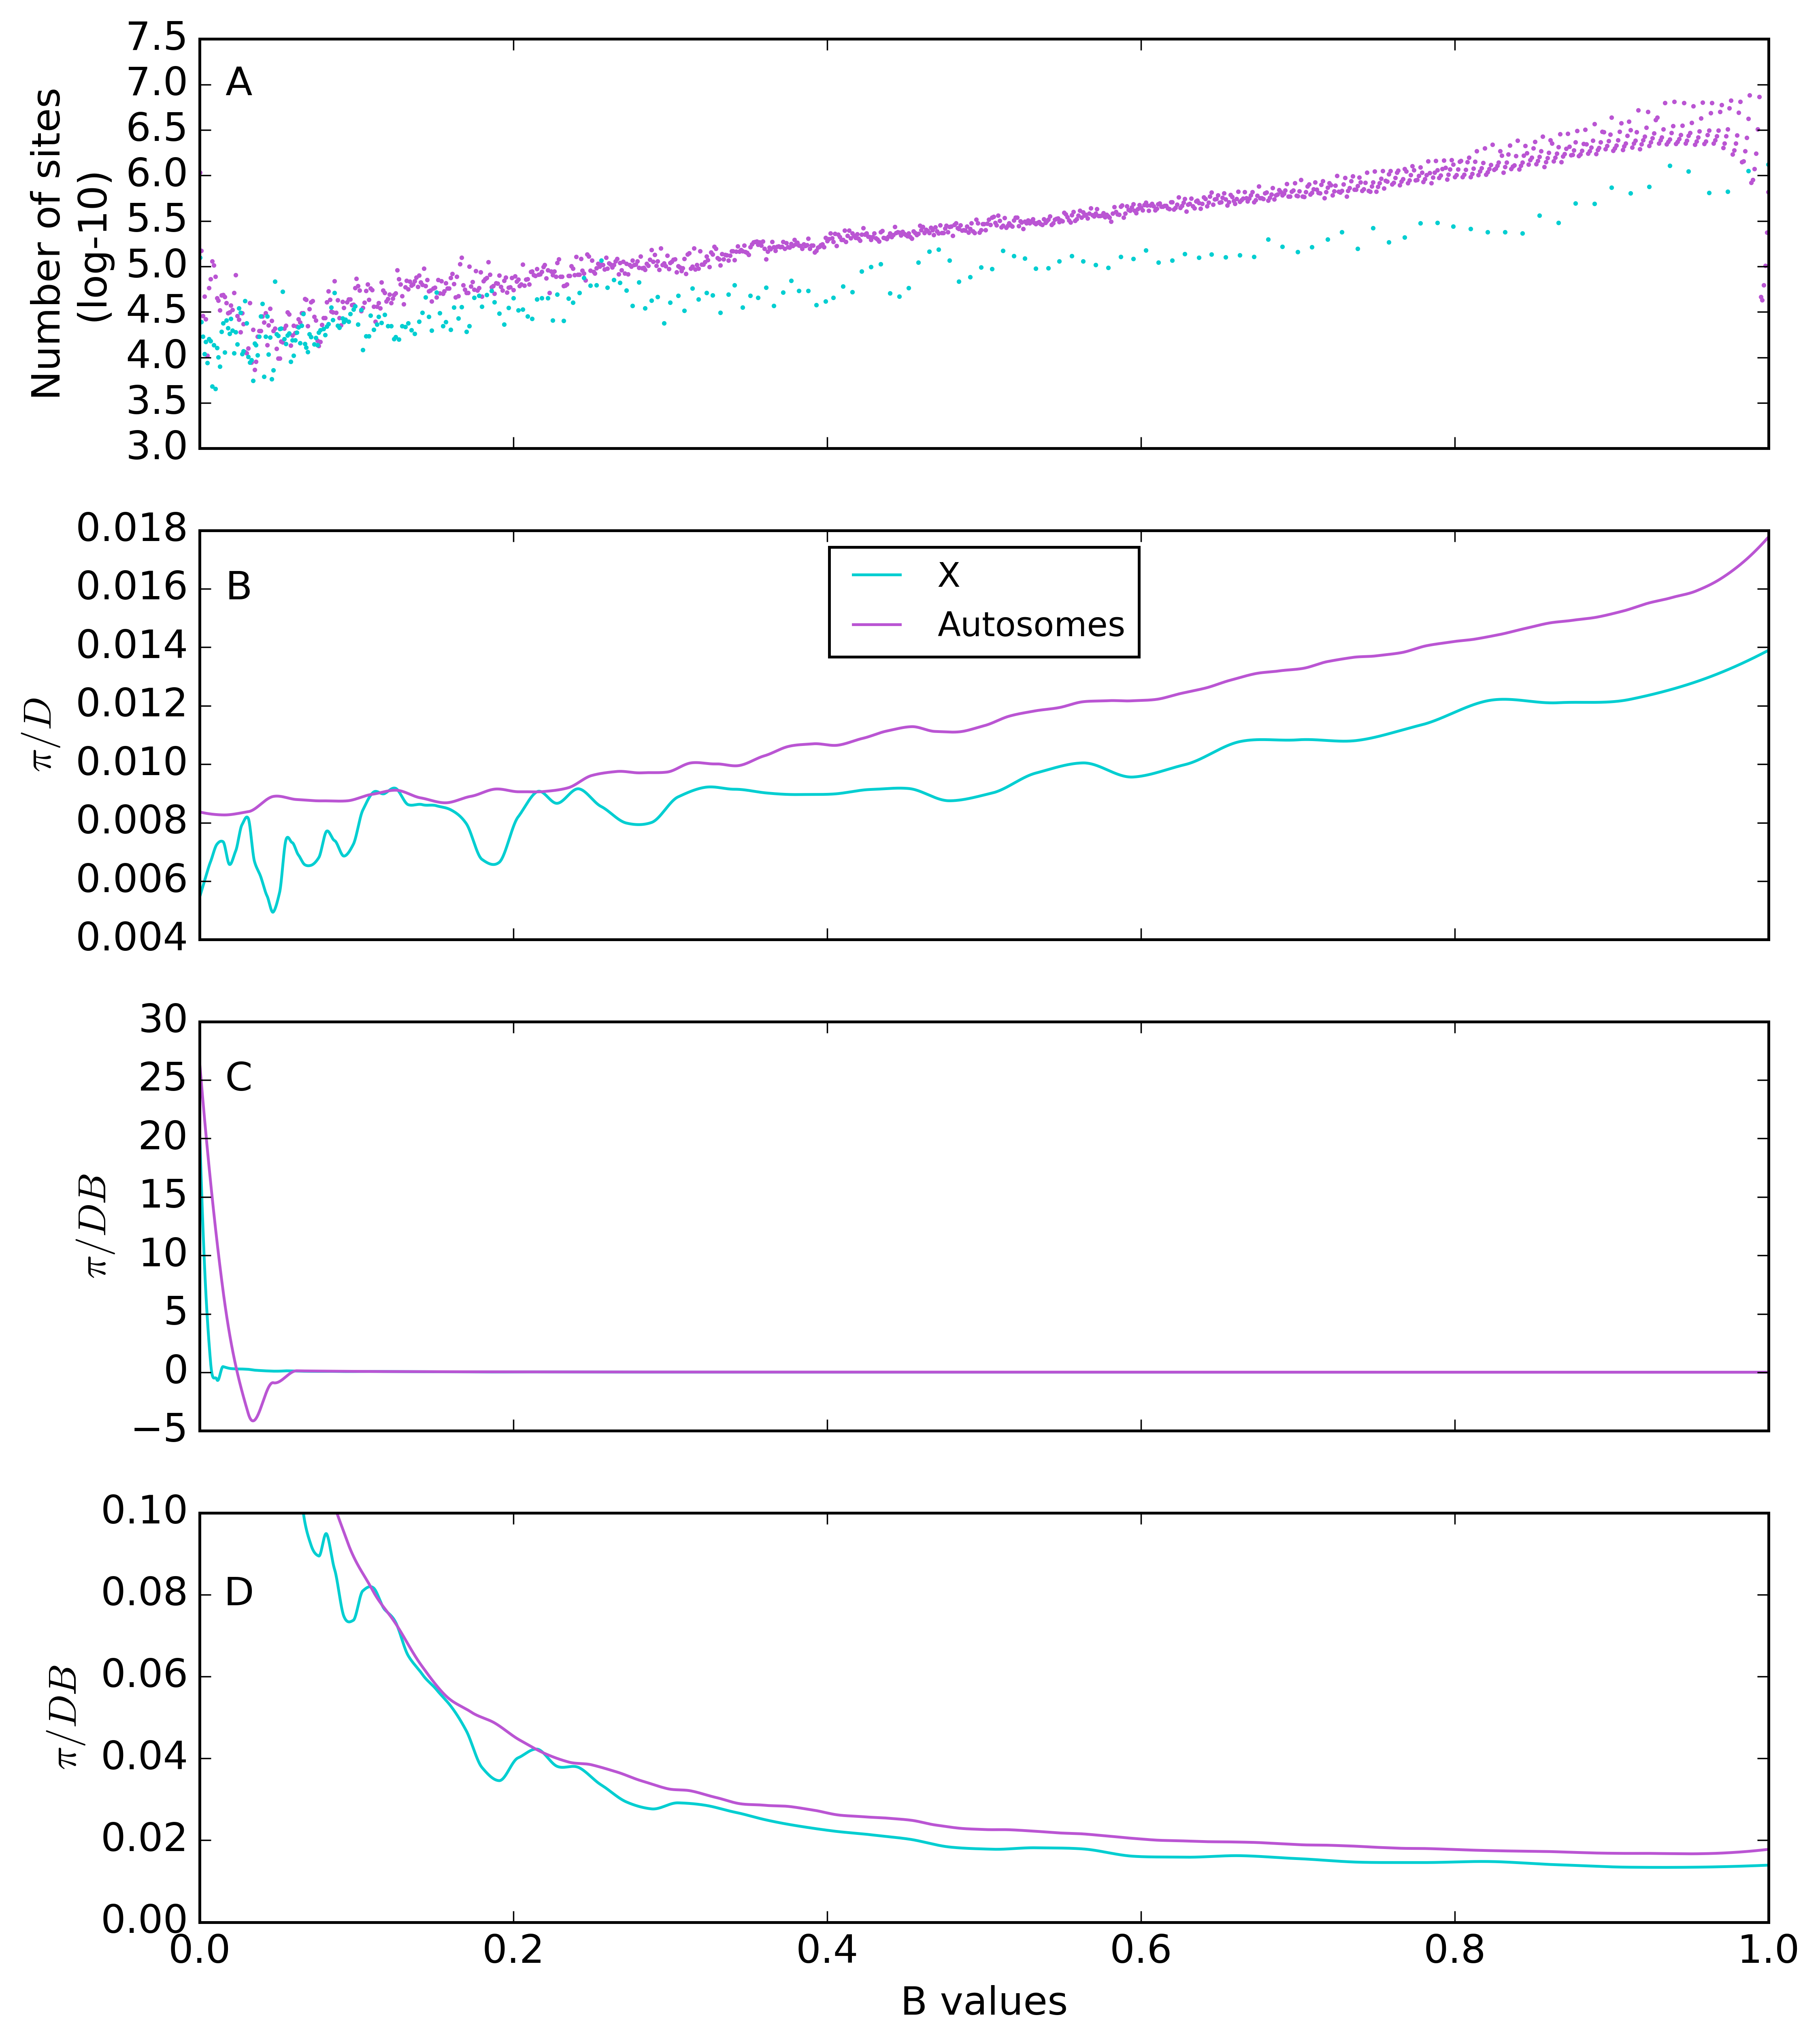

In [23]:
neut = 'YRI'
outg = 'rheMac3'
sortby = 'bval' # 'dist' or 'bval'
span = 0.1
atab = BinnedData('a', neut, outg, sortby, 1)
xtab = BinnedData('x', neut, outg, sortby, 1)

plot_1(atab, xtab, span)
